Credit cs231n.stanford.edu

## Base Functions 
The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

<h2 align="center">BackProp and Optimizers</h2>
<img src="img/bp.png" width="600">

In [9]:
import numpy as np
from scipy.optimize import check_grad
from gradient_check import eval_numerical_gradient_array

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

<h3>Grad Check</h3>

<img src="img/gc.png" width="600">

<h3>Softmax Loss Layer</h3>
<img src="./img/loss.png" width="300">
<img src="./img/log.png" width="600">

In [30]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    #reg = 1
    
    
    f_i = x[np.arange(len(x)), y]
    f_sum = np.sum(np.exp(x), axis = 1)
    loss = np.sum(-f_i + np.log(f_sum)) / len(x)
    
    f_sum = np.sum(np.exp(x), axis = 1, keepdims = True)
    mask = np.zeros_like(x)
    mask[np.arange(len(x)), y] = 1
    dx = -(mask - np.exp(x) / f_sum) / len(x)

   
    return loss, dx

In [31]:
y = np.random.randint(0, 3, 10)
dx = lambda x: softmax_loss(x.reshape((10, 3)), y)[1].reshape(-1)
loss = lambda x: softmax_loss(x.reshape((10, 3)), y)[0]

In [32]:
print ('loss is a scalar\n', loss(np.random.random((10, 3))))

loss is a scalar
 1.0402848592931668


In [33]:
print( 'gradient is a matrix with shape 10x3\n', dx(np.random.random((10, 3))))

gradient is a matrix with shape 10x3
 [ 0.02724988 -0.06131146  0.03406158  0.02053912 -0.06239301  0.04185389
  0.03304523  0.0344869  -0.06753213  0.04237972  0.02650211 -0.06888183
  0.0209521   0.04701141 -0.06796351  0.03326831 -0.07526779  0.04199948
  0.04117061 -0.08098566  0.03981505  0.02464471  0.03233042 -0.05697514
 -0.05751179  0.02989984  0.02761195  0.04385635  0.02405185 -0.0679082 ]


In [34]:
print('difference should be ~10e-8', check_grad(loss, dx, np.random.random((10, 3)).reshape(-1)))

difference should be ~10e-8 8.390872708078433e-08


<h3>Dense Layer</h3>
<img src="img/lin.png" width="300">

In [78]:
x.reshape(10, 6).T.shape

(6, 10)

In [53]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    #############################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You     #
    # will need to reshape the input into rows.                                 #
    #############################################################################
    N = len(x)
    D = np.product(x.shape[1:])
    out = (np.dot(x.reshape(N, D), w) + b)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    
    cache = (x, w, b)
    return out, cache

In [139]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


In [89]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    #############################################################################
    # TODO: Implement the affine backward pass.                                 #
    #############################################################################
    D = np.product(x.shape[1:])
    N = len(x)
    dx = np.dot(dout, w.T).reshape(x.shape)
    dw = np.dot(x.reshape(N, D).T, dout)
    db = np.sum(dout, axis = 0)
    
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx, dw, db

In [90]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print( 'dx error: ', rel_error(dx_num, dx))
print( 'dw error: ', rel_error(dw_num, dw))
print( 'db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.0435867027554953e-08
dw error:  1.05022570882252e-10
db error:  1.8439327395560747e-11


<h3>ReLu Layer</h3>

$$ReLu(x) = max(0, x)$$

In [92]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    #############################################################################
    # TODO: Implement the ReLU forward pass.                                    #
    #############################################################################
    out = np.maximum(0, x)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = x
    return out, cache

In [94]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


In [135]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    #############################################################################
    # TODO: Implement the ReLU backward pass.                                   #
    #############################################################################
    mask = x > 0
    dx = dout * mask
    #dx[~mask] = 0 
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx

In [136]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756228186800854e-12


<h3>Two Layer Fully Connected Neural Net with SGD</h3>

In [137]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%pylab inline

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

/home/dzheglov/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/dzheglov/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


/home/dzheglov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


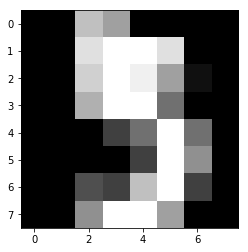

In [138]:
pylab.imshow(X[5].reshape((8, 8)), cmap='gray')

In [182]:
W1, b1 = np.random.random((64, 100))/100, np.random.random(100)/100
W2, b2 = np.random.random((100, 10))/100, np.random.random(10)/100

lr = 1e-4

for i in range(50000):
    batch_index = np.random.randint(0, X_train.shape[0], 100)
    batch_X, batch_y = X_train[batch_index], y_train[batch_index]
    # ------------ Train ----------------- 
    # Forward Pass
    out1, cache1 = affine_forward(batch_X, W1, b1) # Dense Layer
    out2, cache2 = relu_forward(out1)              # ReLu Layer
    out3, cache3 = affine_forward(out2,    W2, b2)# Dense Layer 
    tr_loss, dx = softmax_loss(out3, batch_y)      # Loss Layer 
    
    # Backward Pass
    dx2, dw2, db2 = affine_backward(dx , cache3)
    dxr = relu_backward(dx2, cache2)
    dx1, dw1, db1 = affine_backward(dxr , cache1)
    # Updates
    W1 = W1 - lr * dw1 
    b1 = b1 - lr * db1
    W2 = W2 - lr * dw2
    b2 = b2 - lr * db2
    # ------------ Test ----------------- 
    # Forward Pass
    #te_loss = 0
    # Predict
    #y_pred = np.exp(out3) / np.sum(np.exp(out3))#...
    #
    
    if i % 1000 == 0:
        # Predict
        out1, cache1 = affine_forward(X_test, W1, b1) # Dense Layer
        out2, cache2 = relu_forward(out1)              # ReLu Layer
        out3, cache3 = affine_forward(out2, W2, b2)
        te_loss, dx = softmax_loss(out3, y_test)
        y_pred = np.argmax(np.exp(out3) / np.sum(np.exp(out3)), axis = -1)#...
        print('epoch %s:' % i)
        print('\t tr_loss %.2f' % tr_loss)
        print('\t te_loss %.2f' % te_loss)
        print('\t te_acc %s' % accuracy_score(y_pred, y_test))

epoch 0:
	 tr_loss 2.30
	 te_loss 2.31
	 te_acc 0.0962962962962963
epoch 1000:
	 tr_loss 2.29
	 te_loss 2.30
	 te_acc 0.07962962962962963
epoch 2000:
	 tr_loss 2.27
	 te_loss 2.29
	 te_acc 0.09259259259259259
epoch 3000:
	 tr_loss 2.27
	 te_loss 2.28
	 te_acc 0.2074074074074074
epoch 4000:
	 tr_loss 2.23
	 te_loss 2.24
	 te_acc 0.3851851851851852
epoch 5000:
	 tr_loss 2.16
	 te_loss 2.18
	 te_acc 0.4
epoch 6000:
	 tr_loss 2.09
	 te_loss 2.08
	 te_acc 0.5259259259259259
epoch 7000:
	 tr_loss 1.91
	 te_loss 1.92
	 te_acc 0.6796296296296296
epoch 8000:
	 tr_loss 1.71
	 te_loss 1.71
	 te_acc 0.7351851851851852
epoch 9000:
	 tr_loss 1.48
	 te_loss 1.49
	 te_acc 0.7462962962962963
epoch 10000:
	 tr_loss 1.33
	 te_loss 1.28
	 te_acc 0.7870370370370371
epoch 11000:
	 tr_loss 1.21
	 te_loss 1.11
	 te_acc 0.812962962962963
epoch 12000:
	 tr_loss 0.89
	 te_loss 0.96
	 te_acc 0.8314814814814815
epoch 13000:
	 tr_loss 0.79
	 te_loss 0.84
	 te_acc 0.8388888888888889
epoch 14000:
	 tr_loss 0.73
	 te_